In [1]:
import read_data
import feature_extraction as f
import frequency_ecg as fr_ecg
import biosppy as bsp
import numpy as np
import time
import matplotlib.pyplot as plt
from ecgdetectors import Detectors
from hrv import HRV
from scipy import stats
import scipy as scpy
import cvxEDA as cvx


In [2]:
data = read_data.execute()

[[]]
Reading data S2
One subject data (1484700, 3)
15.231505870819092
(1484700, 3)
La forma de los datos que devuelvo es: (1484700, 3)


42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
42000
14700


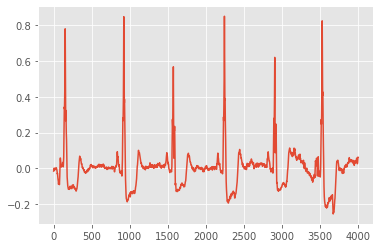

0.20567917823791504


In [36]:
mps = 700
eda = data[:,0]
ecg = data[:,1]

detector = Detectors(mps)
hrv_class = HRV(mps)
#r_peaks = detector.pan_tompkins_detector(ecg)
#print(get_time_domain_features(r_peaks[:]).get('rmssd'))
#split_in(data, 60)

splitted = split_in_seconds(data, mps, 60)
#print(splitted[0][:,1][:3])
start = time.time()
for i, v in enumerate(splitted):
    print(len(v))
    #ecg_processing(splitted[i][:,1])
ecg_processing(splitted[-1][-3999:,1])
plt.plot(splitted[-1][-3999:,1])
plt.show()
print(time.time()-start)
#splitted[0][:2] = 


In [14]:
# HRV y esas cosas que se hacen
# Llamar despues de split_in_seconds
def ecg_processing(ecg_signal):
    mean = np.mean(ecg_signal)
    median = np.median(ecg_signal)
    std = np.std(ecg_signal)
    skewness = stats.skew(ecg_signal)
    kurtosis = stats.kurtosis(ecg_signal)
    #print(f"Media: {mean}\nMediana: {median}\nSTD: {std}\nSkewness: {skewness}\nKurtosis: {kurtosis}")
    
    r_peaks = detector.pan_tompkins_detector(ecg_signal)
    rmssd = hrv_class.RMSSD(r_peaks)
    sdsd = hrv_class.SDSD(r_peaks)
    sdrr = hrv_class.SDNN(r_peaks)
    #print(f"RMSSD: {rmssd}\nSDSD: {sdsd}\nSDRR_RMSSD: {sdrr/rmssd}")
    pNN50 = hrv_class.pNN50(r_peaks)
    pNN20 = hrv_class.pNN20(r_peaks)
    #print(f"pNN50: {pNN50}\npNN20: {pNN20}")
    
    # A PARTIR DE AQUI, EL CODIGO ES DE PICKUS

    
    SD1 = (1 / np.sqrt(2)) * sdsd
    SD2 = np.sqrt((2 * sdrr ** 2) - (0.5 * sdsd ** 2))
    
    # Analisis de frecuencias 
    intervals = hrv_class._intervals(r_peaks)
    freq = fr_ecg.frequencyDomain(intervals)
    #print(f"SD1: {SD1}\nSD2: {SD2}\nfreq: {freq}")
    
    relative_rr(intervals)
    #print(len(r_peaks))
    

In [13]:
def relative_rr(intervals):
    """
        intervals: Intrevalos RR en milisegundos
    """
    relative_rr_sig = []
    
    # Para cada par, aplico la formula del paper
    for idx, r in enumerate(intervals):
        if idx == 0:
            pass
        else:
            # 2 [RRi - RRi-1 / RRi + RRi-1]
            RRi = 2*((r - intervals[idx-1]) /(r + intervals[idx-1]))
            relative_rr_sig.append(RRi)
            
    # Saco todas las variables temporales de la misma forma que con los intervalos RR originales
    mean = np.mean(relative_rr_sig)
    median = np.median(relative_rr_sig)
    std = np.std(relative_rr_sig)
    skewness = stats.skew(relative_rr_sig)
    kurtosis = stats.kurtosis(relative_rr_sig)
    #print(f"DATOS DE RELATIVE_RR:\nMedia: {mean}\nMediana: {median}\nSTD: {std}\nSkewness: {skewness}\nKurtosis: {kurtosis}")
        

In [5]:
# Cojo un filtro FIR de 1.5Hz, lowpass y orden 32 para procesar la señal EDA
output_signal = scpy.signal.filtfilt(b, a, input_signal)

filtro = bsp.tools.get_filter(ftype='FIR', band='lowpass', order = 32, frequency=1.5, sampling_rate= 700)
print(f"Filtro = {filtro[0]}")


Filtro = [0.00457856 0.0050892  0.00659454 0.0090392  0.01233124 0.01634563
 0.02092911 0.02590608 0.03108543 0.0362679  0.04125387 0.04585106
 0.04988207 0.05319125 0.05565076 0.05716556 0.05767708 0.05716556
 0.05565076 0.05319125 0.04988207 0.04585106 0.04125387 0.0362679
 0.03108543 0.02590608 0.02092911 0.01634563 0.01233124 0.0090392
 0.00659454 0.0050892  0.00457856]


In [20]:
import neurokit as nk
splitted = split_in_seconds(data, 700, 60)
#print(len(splitted[1][:,0]))

processed_eda = nk.eda_process(splitted[37][:,0], sampling_rate=700)

print(processed_eda)
peaks = processed_eda['df']['SCR_Peaks']
print(processed_eda['df']['SCR_Peaks'][1676])
tonic, phasic = nk.cvxEDA(splitted[0][:,0], sampling_rate=700)
print(phasic[1676])

x = processed_eda['df']['SCR_Onsets']

nan_array = np.isnan(x)
not_nan_array = ~ nan_array
x = x[not_nan_array]
#print(x)
onsets = processed_eda['EDA']['SCR_Onsets']

#print(processed_eda['df']['EDA_Phasic'])

{'df':         EDA_Raw  EDA_Filtered  EDA_Phasic  EDA_Tonic  SCR_Onsets  \
0      5.710983      5.698468    0.000000   2.678125         NaN   
1      5.719376      5.698407    0.000000   2.677548         NaN   
2      5.706406      5.698346    0.248302   2.676971         NaN   
3      5.712509      5.698285    0.247812   2.676394         NaN   
4      5.727005      5.698222    0.247323   2.675818         NaN   
...         ...           ...         ...        ...         ...   
41995  4.522324      4.505711    0.059883  -1.651966         NaN   
41996  4.494095      4.505707    0.059864  -1.652084         NaN   
41997  4.504013      4.505703    0.059844  -1.652202         NaN   
41998  4.512024      4.505698    0.059825  -1.652321         NaN   
41999  4.512405      4.505694    0.059806  -1.652439         NaN   

       SCR_Recoveries  SCR_Peaks  
0                 NaN        NaN  
1                 NaN        NaN  
2                 NaN        NaN  
3                 NaN        NaN  
4

In [182]:
[r, p, t, l, d, e, obj] = cvx.cvxEDA(splitted[0][:,0], 1/mps)

     pcost       dcost       gap    pres   dres
 0: -5.1226e+05 -5.1222e+05  4e+04  2e+02  2e+01
 1: -5.1222e+05 -5.1294e+05  7e+02  3e+00  3e-01
 2: -5.1223e+05 -5.1227e+05  4e+01  5e-02  4e-03
 3: -5.1225e+05 -5.1226e+05  4e+00  3e-03  2e-04
 4: -5.1226e+05 -5.1226e+05  2e+00  1e-03  1e-04
 5: -5.1226e+05 -5.1226e+05  9e-01  6e-04  5e-05
 6: -5.1226e+05 -5.1226e+05  4e-01  3e-04  2e-05
 7: -5.1226e+05 -5.1226e+05  2e-01  1e-04  8e-06
 8: -5.1226e+05 -5.1226e+05  6e-02  3e-05  2e-06
 9: -5.1226e+05 -5.1226e+05  1e-02  2e-06  2e-07
10: -5.1226e+05 -5.1226e+05  1e-02  1e-06  1e-07
11: -5.1226e+05 -5.1226e+05  3e-03  2e-07  2e-08
12: -5.1226e+05 -5.1226e+05  2e-03  2e-07  1e-08
13: -5.1226e+05 -5.1226e+05  8e-04  4e-08  8e-09
14: -5.1226e+05 -5.1226e+05  8e-04  3e-08  7e-09
15: -5.1226e+05 -5.1226e+05  2e-04  5e-09  7e-09
Optimal solution found.


In [219]:
print(r)

[0.         0.         0.06528074 ... 0.00627628 0.00627285 0.00626942]


In [4]:
def split_in_seconds(data, sampling_rate, seconds):
    rang = list(range(0, len(data), sampling_rate*seconds))
    rang.pop(0)
    splitted = np.split(data, rang)
    return splitted